In [79]:
import numpy as np
%load_ext autoreload
%autoreload 2

from core.gradient_descent import *
from core.visualizer import *
from core.optimizer_evaluator import *
from core.utils import fn_sum
from core.analzyer import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Сравнение модификаций стохостического градиентного спуска

## TODO: тут должны быть разные примеры функций, а после должен идти вывод по всем параметрам

18
Best value found: x* = [-0.00508985  0.00508985] with f(x*) = 0.000719172231194831
16
Best value found: x* = [ 0.00368153 -0.00368153] with f(x*) = 0.00037625219717996543


Text(0.5, 0.98, 'rpms')

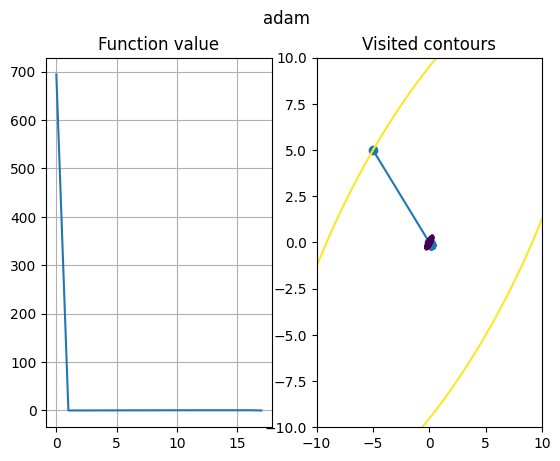

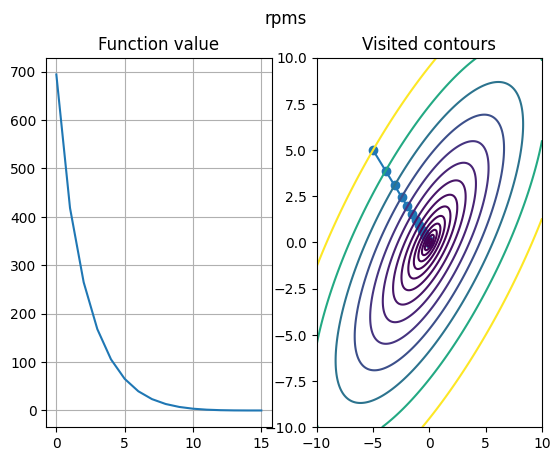

In [80]:
roi=SearchRegion2d((-10, 10), (-10, 10))

f1 = generate_positive_definite_quadratic_form(2, 4, random_orthonormal_basis)
f2 = generate_positive_definite_quadratic_form(2, 10, random_orthonormal_basis)
f = fn_sum(f1, f2)
df = fn_sum(f1.gradient_function(), f2.gradient_function())
x0 = np.array([-5, 5])

def terminate(ff, steps):
    return ff(steps[-1]) < 0.01 or len(steps) > 1000

points1 = steepest_descent_adam(0.9, 0.999)(f, df, x0, bin_search_with_iters(5), terminate)
print(f"{len(points1)}")
visualize_optimizing_process(f, roi, np.array(points1)).suptitle('adam')

batch = 2
points2 = gradient_descent_minibatch_rms_prop(0.2)(
    [f1, f2], [f1.gradient_function(), f2.gradient_function()], batch, x0,
    exponential_learning_scheduler(1, 0.2, batch, len([f1, f2])),
    terminate
)

print(f"{len(points2)}")
visualize_optimizing_process(f, roi, np.array(points2)).suptitle('rpms')


### Сходимость

### Надежность

### Требуемость к ресурсам

Рассмотрим потанциальные критерии для сравнения производительности:
1. Потребление памяти
2. Время исполнения
3. Количество арифмитических операций

Заметим, что все реализации алгоритмов потребляют памяти прямопропорционально размеру батча, остальные расходы памяти слишком малы, чтобы их учитывать. Поэтому этот критерий не подходит для сравнения.

Время исполнения также является не очень подходящим критерием для сравнения алгоритмов, так как он сильно зависит от железа, компилятора/интерпритатора языка реализации и его возможности оптицмизации. Даже при получении некоторых измерений довольно сложно сделать хоть сколько-нибудь общие выводы о производительности.

При сравнении количество арифмитических операций стоит учитывать, что основной вклад будет производиться от вычисления самой функции или ее производной. Поэтому для получения сравнительной характеристики методов будет использоваться подсчет количества вычислений функции или ее производной, а не всех арифмитических операций.


In [81]:
from tabulate import tabulate

fcnt = 4

for batch in range(1, fcnt + 1):
    data = {}

    for i in range(5):
        fs = [generate_positive_definite_quadratic_form(5, 3, random_orthonormal_basis) for _ in range(fcnt)]
        dfs = [f.gradient_function() for f in fs]
        test = test_perfomance(fs, dfs, batch, np.array([-5, -5, 2, -3, 1]))
        for label, result in test:
            if label not in data:
                data[label] = []
            data[label].append(result)

    print(f"With batch = {batch}")
    print(tabulate(data, headers="keys", tablefmt="grid"))
    print()

With batch = 1
+-------------+------------+------------+-----------+-----------+---------+
| Minibatch   | Momentum   | Nesterov   | AdaGrad   | RMSProp   | Adam    |
+=============+============+============+===========+===========+=========+
| 39/8        | 44/9       | 64/13      | 44/9      | 354/71    | 4908/80 |
+-------------+------------+------------+-----------+-----------+---------+
| 44/9        | 39/8       | 69/14      | 44/9      | 309/62    | 5032/83 |
+-------------+------------+------------+-----------+-----------+---------+
| 39/8        | 49/10      | 64/13      | 34/7      | 354/71    | 5064/84 |
+-------------+------------+------------+-----------+-----------+---------+
| 44/9        | 39/8       | 74/15      | 44/9      | 269/54    | 5016/83 |
+-------------+------------+------------+-----------+-----------+---------+
| 34/7        | 44/9       | 74/15      | 44/9      | 329/66    | 4980/82 |
+-------------+------------+------------+-----------+-----------+--------

### Сравнение с разным батчем

In [82]:
data = {}

for _ in range(5):
    fs = [generate_positive_definite_quadratic_form(2, 10, random_orthonormal_basis) for _ in range(5)]
    dfs = [f.gradient_function() for f in fs]
    result = test_batch(fs, dfs, np.array([-5, 5]), lambda batch: fixed_step_search(1))

    for key, value in result:
        if key not in data:
            data[key] = []
        data[key].append(value)

print(tabulate(data, headers="keys", tablefmt="grid"))

target point = [9.50097174e-11 1.77590128e-10], with value = 2.8915297737877177e-19
target point = [2.22778998e-11 4.30206149e-11], with value = 2.98030227876986e-20
target point = [-2.54968930e-11 -1.57492091e-11], with value = 7.81176923300972e-21
target point = [-2.73943794e-12 -2.70066645e-12], with value = 2.1458036461684473e-22
target point = [-7.10202518e-12  7.10269114e-12], with value = 4.601922343277442e-21
+-------------+-------------+-------------+-------------+-------------+
|   batch = 1 |   batch = 2 |   batch = 3 |   batch = 4 |   batch = 5 |
+=============+=============+=============+=============+=============+
|          16 |          13 |          11 |          11 |          10 |
+-------------+-------------+-------------+-------------+-------------+
|          17 |          13 |          12 |          11 |          10 |
+-------------+-------------+-------------+-------------+-------------+
|          16 |          13 |          12 |          11 |          10 |
+--